Note: Some console outputs (print statements) were generated during the initial model runs in Spanish.
Since these steps involve computationally expensive models (UMAP, HDBSCAN, BERTopic), the notebook
is not re-executed to avoid unnecessary computation. The code has been fully translated into English
for reproducibility, and the stored outputs do not affect the functioning of the notebook.

In [ ]:
import pandas as pd
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from umap import UMAP
from hdbscan import HDBSCAN
from sklearn.feature_extraction.text import CountVectorizer
from pathlib import Path
import os
import re
import time

# Load dataset generated in Notebook 2
df = pd.read_pickle(INPUT_FILE)
print(f"Dataset loaded: {df.shape} rows")
print(f"Columns: {list(df.columns)}")

Dataset loaded: (74759, 19) rows
Columns: ['review_text', 'review_en', 'rating', 'date', 'user_total_reviews', 'user_id', 'is_local_guide', 'lang', 'park_name', 'text_length', 'year', 'month', 'quarter', 'month_name', 'season', 'gender', 'text_bert', 'text_stats', 'text_en_clean']


In [ ]:
import pickle

# Load input documents (light-cleaned text)
documents = df["text_bert"].tolist()

# Load domain stopwords for c-TF-IDF
try:
    with open(PROCESSED_DIR / "stopwords_final_dominio.pkl", "rb") as f:
        stopwords_final = pickle.load(f)
    print(f"Domain stopwords loaded ({len(stopwords_final)} terms).")
except FileNotFoundError:
    stopwords_final = []
    print("Domain stopwords file not found. Using empty list.")

stopwords_list = list(stopwords_final)

Domain stopwords loaded (1318 terms).


In [ ]:
from sentence_transformers import SentenceTransformer
import torch

# Device selection
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device.upper()}")

# Load multilingual embedding model
print("Loading multilingual transformer model...")
embedding_model = SentenceTransformer(
    "paraphrase-multilingual-MiniLM-L12-v2",
    device=device
)

# Generate embeddings
docs = df["text_bert"].tolist()
print(f"Generating embeddings for {len(docs)} documents...")

embeddings = embedding_model.encode(
    docs,
    show_progress_bar=True
)

print(f"Embedding matrix shape: {embeddings.shape}")

Utilizando dispositivo: CUDA
Cargando modelo Transformer Multilingüe...


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Generando embeddings para 74759 documentos


Batches:   0%|          | 0/2337 [00:00<?, ?it/s]

Embeddings generados. Dimensiones de la matriz: (74759, 384)


In [ ]:
from umap import UMAP
from hdbscan import HDBSCAN
from sklearn.feature_extraction.text import CountVectorizer
from bertopic import BERTopic

# UMAP dimensionality reduction
umap_model = UMAP(
    n_neighbors=15,
    n_components=5,
    min_dist=0.0,
    metric='cosine',
    random_state=42
)

# HDBSCAN clustering
hdbscan_model = HDBSCAN(
    min_cluster_size=75,
    min_samples=38,
    metric='euclidean',
    cluster_selection_method='eom',
    prediction_data=True
)

# CountVectorizer for c-TF-IDF topic representation
vectorizer_model = CountVectorizer(
    stop_words=stopwords_list,
    min_df=2,
    max_df=0.9
)

print("Submodels configured. Ready for training.")

Sub-modelos configurados. Listos para entrenar.


In [ ]:
print("Starting BERTopic training...")

topic_model = BERTopic(
    embedding_model=embedding_model,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    vectorizer_model=vectorizer_model,
    language="multilingual",
    calculate_probabilities=False,
    verbose=True
)

# Fit using documents and precomputed embeddings
topics, probs = topic_model.fit_transform(docs, embeddings)

# Añadimos los tópicos al dataframe
# df['topic'] = topics

print("Training completed.")

2025-12-09 09:19:08,597 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm


Iniciando entrenamiento de BERTopic...


2025-12-09 09:21:04,404 - BERTopic - Dimensionality - Completed ✓
2025-12-09 09:21:04,406 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-12-09 09:21:10,630 - BERTopic - Cluster - Completed ✓
2025-12-09 09:21:10,653 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-12-09 09:21:12,744 - BERTopic - Representation - Completed ✓


Entrenamiento finalizado


In [ ]:
!pip install --upgrade gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 97.6 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from copy import deepcopy
import gensim.corpora as corpora
from gensim.models.coherencemodel import CoherenceModel

def evaluate_k_bertopic(topic_model, df, k_list, plot=True, top_n_words=10):
    """
    Evaluate topic coherence (c_v) for reduced BERTopic models at different k values.
    The function excludes the noise topic (-1) when computing coherence.
    """

    # Tokenization (prefer domain-cleaned text if available)
    if "text_stats" in df.columns:
        token_docs = [str(doc).split() for doc in df["text_stats"].tolist()]
    else:
        print("'text_stats' not found. Using 'review_text' (less precise for c_v).")
        token_docs = [str(doc).split() for doc in df["review_text"].tolist()]

    # Gensim dictionary
    dictionary = corpora.Dictionary(token_docs)

    # Sort k values (descending) and keep only values below the current number of topics
    current_topics = len(topic_model.get_topic_info()) - 1
    k_list = sorted([k for k in k_list if k < current_topics], reverse=True)

    if not k_list:
        print("Error: All requested k values exceed the number of existing topics.")
        return pd.DataFrame(), 0

    print(f"--- Starting Evaluation (k={k_list}) ---")

    results = []
    model_copy = deepcopy(topic_model)

    for k in k_list:
        try:
            # Reduce topics on the working copy
            model_copy.reduce_topics(df["review_text"].tolist(), nr_topics=k)

            # Identify active topics (exclude noise cluster -1)
            active_topics = [
                t for t in model_copy.get_topic_info()["Topic"]
                if t != -1
            ]
            if not active_topics:
                continue

            # Extract top words for coherence
            topic_words = []
            for topic_id in active_topics:
                words = [w[0] for w in model_copy.get_topic(topic_id)[:top_n_words]]
                topic_words.append(words)

            # Compute coherence
            cm = CoherenceModel(
                topics=topic_words,

--- Iniciando Evaluación (k=[20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4]) ---
   ✅ k=20 | Coherencia ($C_v$): 0.6115
   ✅ k=19 | Coherencia ($C_v$): 0.6190
   ✅ k=18 | Coherencia ($C_v$): 0.6259
   ✅ k=17 | Coherencia ($C_v$): 0.6186
   ✅ k=16 | Coherencia ($C_v$): 0.6308
   ✅ k=15 | Coherencia ($C_v$): 0.6343
   ✅ k=14 | Coherencia ($C_v$): 0.6365
   ✅ k=13 | Coherencia ($C_v$): 0.6527
   ✅ k=12 | Coherencia ($C_v$): 0.6461
   ✅ k=11 | Coherencia ($C_v$): 0.6376
   ✅ k=10 | Coherencia ($C_v$): 0.6918
   ✅ k=9 | Coherencia ($C_v$): 0.7049
   ✅ k=8 | Coherencia ($C_v$): 0.7159
   ✅ k=7 | Coherencia ($C_v$): 0.7010
   ✅ k=6 | Coherencia ($C_v$): 0.6678
   ✅ k=5 | Coherencia ($C_v$): 0.6293
   ✅ k=4 | Coherencia ($C_v$): 0.6014

MEJOR RESULTADO: k=8 (Coherencia: 0.7159)


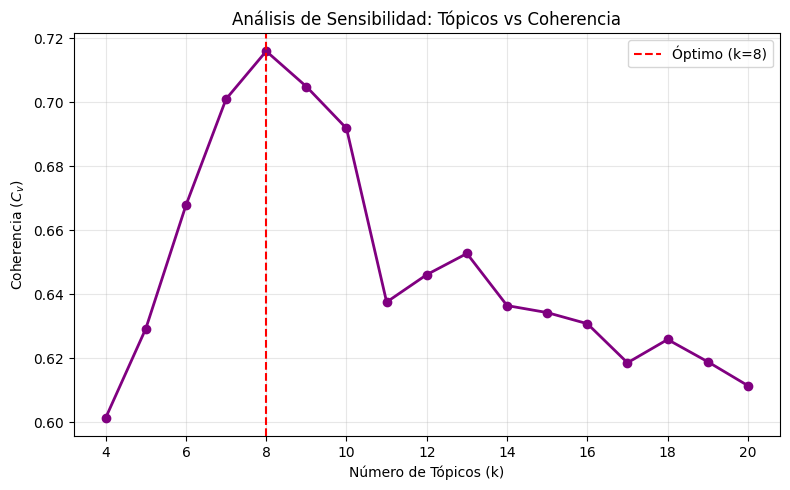

In [ ]:
# List of k values to evaluate
k_values = list(range(4, 21))

df_metrics, best_k = evaluate_k_bertopic(topic_model, df, k_values)

In [ ]:
import copy
import random

# ==============================================================================
# Topic Reduction
# ==============================================================================
print("Applying topic reduction...")

final_model = copy.deepcopy(topic_model)

# Reduce the number of topics
final_model.reduce_topics(docs, nr_topics=9)

# Update topic assignments in the DataFrame
df["topic_id"] = final_model.topics_

print(f"\nReduced model completed. Total topics: {len(final_model.get_topic_info()) - 1}\n")

# ==============================================================================
# Report for Manual Topic Labeling
# ==============================================================================

topic_info = final_model.get_topic_info()

for _, row in topic_info.iterrows():
    topic_id = row["Topic"]
    if topic_id == -1:
        continue

    print(f"TOPIC {topic_id + 1} (Frequency: {row['Count']})")
    print(f"Key Terms: {row['Representation']}")

    # Retrieve representative documents for this topic
    topic_reviews = df[df["topic_id"] == topic_id]["text_bert"].tolist()

    if topic_reviews:
        sample_size = min(10, len(topic_reviews))
        sample_texts = random.sample(topic_reviews, sample_size)

        for t in sample_texts:
            print(f"   - {t[:400]}...")
    else:
        print("   - No examples available in the dataset.")

    print("-" * 80)

Aplicando reducción de tópicos..

✅ Modelo reducido. Total temas: 8

🆔 TÓPICO 1 (Frecuencia: 19704)
🔑 Palabras Clave: ['halloween', 'ferrari', 'land', 'hotel', 'parques', 'très', 'rusas', 'españa', 'montañas', 'agua']
   - Enamorada de este parque de atracciones ! Muy recomendado tanto para adultos como para famílias . Si vienes a Cataluña es obligatorio ir , 100% recomendado !...
   - Esta muy bien , para niños pequeños hay varios juegos y si miras los horarios de las actividades puedes planificar para verlos y después juegos . El parking se paga , 12 € con techo . Salen bien de precio por internet y si sacas la comida también sale bien de precio . no se puede meter comida pero para bebés si . Me encanta el show de loca academia de policía ....
   - El hotel en el que nos alojamos el gold river es una pasada el trato de todo el personal es de 10 , mecere la pena...
   - le parc est magnifique et très grand avec des décor en rapport avec des continents il est ouvert très longtemps pour

In [ ]:
# ==============================================================================
# Topic Label Assignment
# ==============================================================================

topic_labels = {
    -1: "Other / Uncategorized",

    0: "Thematic Offering, Attractions and Resort",
    1: "Queue Management, Express Pass and Accessibility",
    2: "Overall Satisfaction and Enjoyment",
    3: "Food Services and Pricing Policy",
    4: "Weather Conditions and Seasonal Events",
    5: "Critical Complaints and Claims",
    6: "Customer Service and Incident Management",
    7: "Safety, Hygiene and Health Regulations"
}

# Apply labels to the model
final_model.set_topic_labels(topic_labels)

In [ ]:
# Map topic IDs to descriptive labels
df["topic_label"] = df["topic_id"].map(topic_labels)

# Quick validation: no unlabeled rows expected
print(f"Rows without assigned label: {df['topic_label'].isnull().sum()}")

# Sample inspection
display(df[["text_bert", "topic_id", "topic_label"]].sample(5))

Filas sin etiqueta: 0


,text_bert,topic_id,topic_label
55236,No está mal pero es un quiero y no puedo . Le ...,-1,Otros / Sin Categorizar
12069,"Diversión para los niños , el personal que ati...",4,Factores de Clima y Eventos de Temporada
63971,"Nunca habíamos estado , y fuimos con la mejor ...",2,Disfrute y Experiencia de Alto Valor
68811,"Día en familia , muy agradable en medio del campo",2,Disfrute y Experiencia de Alto Valor
33093,Muy buenas atracciones . Buen servicio y todo ...,2,Disfrute y Experiencia de Alto Valor
